<a href="https://colab.research.google.com/github/antoinexp/markov-chains-COM-516/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is provided as a starting point to help you generate random instances G1 and G2 as mentioned in the handout.

You are free to use and modify it at your own convenience.

---



In [1]:
import scipy.stats as st
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
np.random.seed(36)

In [3]:
class DatasetGenerator(object):
    def __init__(self, N=100):
        self.N = N
        self.x = None
        self.v = None
        self.refresh()
  
    def refresh(self):
        raise Exception("undefined")

In [4]:
class G1(DatasetGenerator):
    def refresh(self):
        self.x = st.uniform().rvs((self.N,2))
        self.v = st.uniform().rvs((self.N,))

In [5]:
class G2(DatasetGenerator):
    def refresh(self):
        self.x = st.uniform().rvs((self.N,2))
        self.v = np.exp(st.norm(-0.85, 1.3).rvs((self.N,)))

### Uniform distribution ($\mathcal U([0,1])$) 

In [6]:
g1 = G1()

Examples:

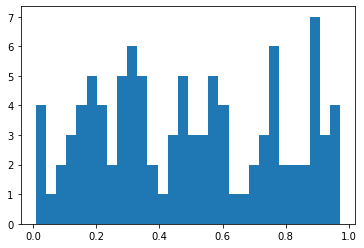

In [7]:
# Plot a histogram of the v array
plt.hist(g1.v, bins=30)
plt.show()

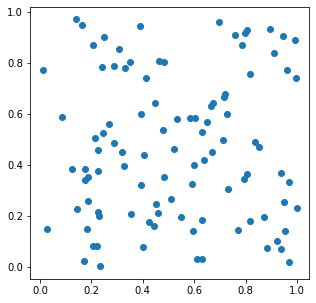

In [8]:
# plot the position of the points
plt.figure(figsize=(5,5))
plt.scatter(g1.x[:,0], g1.x[:,1])
plt.show()

You can refresh the dataset

In [9]:
g1.refresh() # generate a new dataset

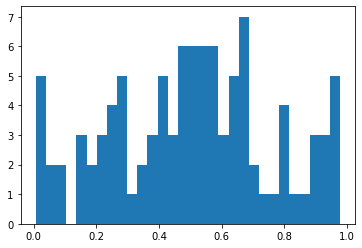

In [10]:
plt.hist(g1.v, bins=30)
plt.show()

Or for instance, you can generate 10 instances and compute the average position of all the points:

In [11]:
m = np.array([0., 0.])

for _ in range(10):
    g1.refresh() # refresh the dataset
    m  += 0.1*g1.x.mean()

print(m)

[0.50442458 0.50442458]


### Test on log-normal distribution

In [12]:
g2 = G2()

Example:

you can use g2 to generate an instance of the lognormal distribution

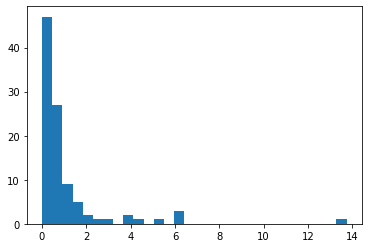

In [13]:
plt.hist(g2.v, bins=30)
plt.show()

In [14]:
g2.refresh() # to generate a new x and v

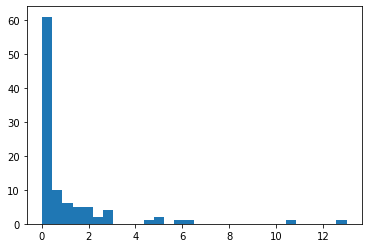

In [15]:
plt.hist(g2.v, bins=30)
plt.show()

---

### Metropolis Hastings

In [16]:
# fill-in this section with your code

In [17]:
g = g2

In [18]:
def max_squared_dist(points):
    N = len(points)
    p1 = points.reshape(1, N, 2)
    p2 = points.reshape(N, 1, 2)
    return np.max(np.sum(np.square(p1 - p2), axis = 2))

def f(_lambda, x, v, N):
    return np.sum(v) - _lambda * N * np.pi * max_squared_dist(x) / 4

In [19]:
%%time
#SpeedTest
n1 = 101
n2 = 101
row, col = np.indices((n1, n2))
points = np.dstack([row, col]).flatten().reshape(n1 * n2, 2)
print(max_squared_dist(points))

20000
Wall time: 5.47 s


In [20]:
def Metropolis_Hasting_step(data, _lambda, selection, scores, remove_duplicates = True, tol = 0):
    ind = np.random.randint(0,data.N, len(selection))
    for i in range(len(selection)):
        mask = np.zeros(data.N, dtype = "bool")
        mask[ind[i]] = True
        proposal = selection[i] ^ mask
        if (np.sum(proposal) > 0):
            old_score = scores[i]
            score = f(_lambda, data.x[proposal], data.v[proposal], data.N)
            if score >= old_score - tol :
                scores[i] = score
                selection[i] = proposal
    if remove_duplicates:
        selection, ids = np.unique(selection, return_index = True, axis = 0)
        scores = scores[ids]    
    return selection, scores

In [21]:
def is_not_local_max(data, _lambda, selection_line, score, tol = 0):
    mask = np.zeros(data.N, dtype = "bool")
    for i in range(data.N):
        mask[i] = True
        proposal = selection_line ^ mask
        if (np.sum(proposal) > 0):
            new_score = f(_lambda, data.x[proposal], data.v[proposal], data.N)
            if new_score >= score - tol:
                return True
        mask[i] = False
    return False

In [22]:
def filter_selection(data, _lambda, selection, scores, tol = 0):
    useless_lines = []
    best_score = np.max(scores)
    useful_count = 0
    for i in range(len(selection)):
        is_best = (scores[i] == best_score)
        is_useful = is_not_local_max(data, _lambda, selection[i], scores[i], data, tol = tol)
        useful_count += is_useful
        if not (is_useful or is_best):
            useless_lines.append(i)
    selection = np.delete(selection, useless_lines, axis = 0)
    scores = np.delete(scores, useless_lines, axis = 0)
    return selection, scores, useful_count > 0

In [23]:
def drop_half(selection, scores, best_selection, best_score):
    if len(scores) <= 1 :
        return selection, scores
    else :
        argmin = np.argmin(scores)
        selection[argmin] = np.copy(best_selection)
        scores[argmin] = best_score
        where = np.where(np.median(scores) <= scores)
        return selection[where], scores[where]

In [38]:
def Metropolis_Hasting(data, _lambda, init_selection = None, plot = False, verbose = False, batch_size = 100, max_iter = 1000, init_tol = 0):
    if init_selection is not None :
        selection = init_selection
    else :
        selection = np.identity(data.N, dtype = "bool")[:batch_size]
    scores = np.array([f(_lambda, data.x[selection[i]], data.v[selection[i]], data.N) for i in range(len(selection))])
    i = 0
    best_scores = []
    tols = []
    best_score = np.max(scores)
    time_best_reached = 0
    best_selection = selection[0]
    t = init_tol
    while (i < max_iter):
        tols.append(t)
        selection, scores = Metropolis_Hasting_step(data, _lambda, selection, scores, remove_duplicates = False, tol = t)

        best = np.max(scores)
        if best > best_score:
            best_score = best
            time_best_reached = i
            best_selection = np.copy(selection[np.argmax(scores)])
        best_scores.append(best)
        #if i % 100 == 0:
         #   selection, scores, _ = filter_selection(selection, scores, data, tol = t)
        i += 1
        t -= init_tol/(0.6 * max_iter)
        t = max(t, 0)
    improvement_possible = is_not_local_max(data, _lambda, best_selection, best_score)
    if (verbose):
        print("Score : {}".format(np.max(scores)))
        print("Number of cities : {}".format(np.sum(selection[np.argmax(scores)])))
        print("Batch size : {}".format(len(scores)))
        print("Number of iterations = {}".format(i))
        print("Number of iterations until finding the best score = {}".format(time_best_reached))
        print("Improvement possible from best : {}".format(improvement_possible))
    if (plot):
        plt.figure(figsize=(5,5))
        plt.plot(np.arange(i), best_scores, c = "g")
        plt.title("Evolution of the score")
        plt.xlabel("#iteration")
        plt.ylabel("Best Score")
        #plt.savefig("score_evolution_G1_05.png")
        plt.show()
        plt.figure(figsize=(5,5))
        plt.plot(np.arange(i), tols, c = "r")
        plt.title("Tolerance")
        plt.xlabel("#iteration")
        plt.ylabel("Tolerance")
        #plt.savefig("tolerance_time.png")
        plt.show()
        plt.figure(figsize=(5,5))
        selected = best_selection
        plt.scatter(data.x[:,0], data.x[:,1])
        plt.scatter(data.x[selected,0], data.x[selected,1])
        plt.show()
    return best_selection, np.max(np.array(best_scores)), time_best_reached

Score : 6.005051036563401
Number of cities : 50
Batch size : 50
Number of iterations = 1500
Number of iterations until finding the best score = 1084
Improvement possible from best : False


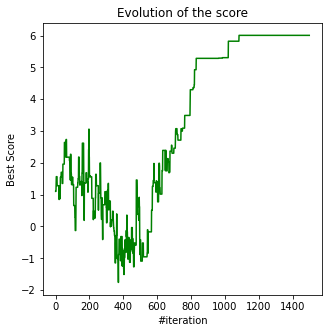

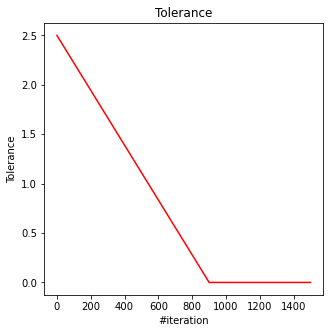

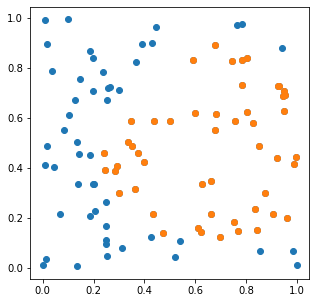

6.005051036563401
Wall time: 6.96 s


In [40]:
%%time
best_selection, best, time_best_reached = Metropolis_Hasting(g1,0.5, plot = True, verbose = True, batch_size = 50, max_iter = 1500, init_tol = 2.5)
print(best)#6.005051036563401 with g1 lambda = 0.5

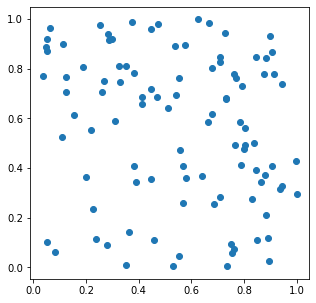

In [26]:
plt.figure(figsize=(5,5))
plt.scatter(g.x[:,0], g.x[:,1])
plt.show()

In [27]:
%%time
N = 7
minimums = []
maximums = []
means    = []
stds     = []
c_minimums = []
c_maximums = []
c_means    = []
c_stds     = []
G = g2
l_range = np.linspace(0, 2, 101)
counter = 0
for l in l_range:
    test_scores = []
    n_cities = []
    for i in range(N):
        sel, score, time_best_reached = Metropolis_Hasting(G, l, plot = False, verbose = False, batch_size = 50, max_iter = 1500, init_tol = 2.5)
        test_scores.append(score)
        n_cities.append(np.sum(sel))
        print("\rProgress : {:.3f}%".format((counter + 1) / N / len(l_range) * 100), end = "")
        counter += 1
    #print("Min  : {}".format(np.min(test_scores)))
    #print("Max  : {}".format(np.max(test_scores)))
    #print("Mean : {}".format(np.mean(test_scores)))
    #print("Std  : {}".format(np.std(test_scores)))
    minimums.append(np.min(test_scores))
    maximums.append(np.max(test_scores))
    means.append(np.mean(test_scores))
    stds.append(np.std(test_scores))
    c_minimums.append(np.min(n_cities))
    c_maximums.append(np.max(n_cities))
    c_means.append(np.mean(n_cities))
    c_stds.append(np.std(n_cities))
print("\nDone !")

Progress : 100.000%
Done !
Wall time: 1h 46min 49s


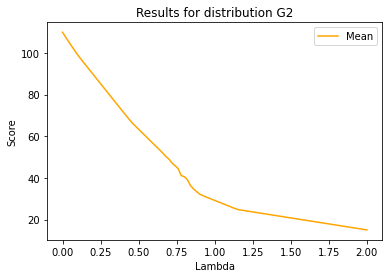

In [33]:
#plt.plot(l_range, minimums, c = "r", label = "Minimum")
#plt.plot(l_range, maximums, c = "g", label = "Maximum")
plt.plot(l_range, means, c = "orange", label = "Mean")
plt.title("Results for distribution G2")
plt.xlabel("Lambda")
plt.ylabel("Score")
plt.legend()
plt.savefig("testResultsLambdaFinerGridG2.png")
plt.show()

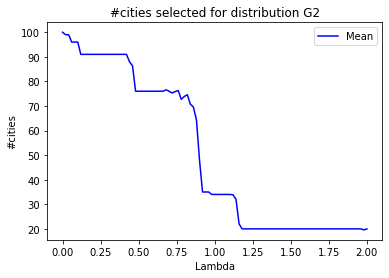

In [31]:
#plt.plot(l_range, c_minimums, c = "r", label = "Minimum")
#plt.plot(l_range, c_maximums, c = "g", label = "Maximum")
plt.plot(l_range, c_means, c = "b", label = "Mean")
plt.title("#cities selected for distribution G2")
plt.xlabel("Lambda")
plt.ylabel("#cities")
plt.legend()
plt.savefig("CitiesG2 Lambda FinerGrid.png")
plt.show()